In [2]:
%load_ext autoreload
%autoreload 2

In [98]:
import sys
sys.path.append("../")

from src.data.common import DownloadedRepositories, load_repositories_json
from src.data.sharings import find_most_recent_commit_sharings, find_most_recent_pr_sharings, find_most_recent_issue_sharings
from src.utils.compare import *

from pathlib import Path

import time
import json
import tqdm
import contextlib

import numpy as np
import pandas as pd

import joblib
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Definitions and declarations

In [3]:
repos = load_repositories_json(Path('../data/repositories_download_status.json'))

Loading info about cloned repos from '../data/repositories_download_status.json'...


In [5]:
# information about example repository
repos['sqlalchemy/sqlalchemy']

{'project': 'sqlalchemy_sqlalchemy',
 'repository': 'sqlalchemy/sqlalchemy',
 'repository_url': 'https://github.com/sqlalchemy/sqlalchemy.git',
 'repository_path': '/mnt/data/MSR_Challenge_2024/repositories/sqlalchemy_sqlalchemy'}

In [7]:
dataset_dir = '../data/external/DevGPT'
dataset_dir

'../data/external/DevGPT'

https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution/58936697#58936697

an alternative could be to use [pqmd](https://pqdm.readthedocs.io/): a TQDM and concurrent futures wrapper to allow enjoyable paralellization of iterating through an Iterable with a progress bar

In [85]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument
    
    Example:
        >>> from math import sqrt
        >>> from joblib import Parallel, delayed
        >>> with tqdm_joblib(tqdm(desc="My calculation", total=10)) as progress_bar:
        ...     Parallel(n_jobs=16)(delayed(sqrt)(i**2) for i in range(10))
    """
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Commit sharings

In [15]:
commit_sharings_path = find_most_recent_commit_sharings(Path(dataset_dir), verbose=True)
with open(commit_sharings_path) as f:
    commit_data = json.load(f)

Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


In [62]:
# all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'))


# # get url
# diffs = {}
# bad_url = []
# for source in tqdm.tqdm(data['Sources']):

#     try:
#         R = source['RepoName']
#         S  = source['Sha']
#         the_repo = all_repos.repo(R)
#         curr_diff = the_repo.unidiff(S) 
#         diffs[(R,S)] = curr_diff
#     except:
#         bad_url.append((R,S))

In [17]:
def run_joblib(source, conv, compare):
    
    if 'Conversations' not in conv:
        return None, {}
    
    all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'), verbose=False)

    R = source['RepoName']
    S = source['Sha']
    U = source['URL']
    curr_diff = None
    try:
        the_repo = all_repos.repo(R)
        curr_diff = the_repo.unidiff(S) 
    except:
        pass
    
    if curr_diff:
        return U, diff_to_conversation(curr_diff, conv, compare=compare)
    
    return U, {}

In [64]:
#ret = Parallel(n_jobs=-1)(delayed(run_joblib)(source, conv, compare=CompareLines) for source in tqdm.tqdm(data['Sources']) for conv in source['ChatgptSharing'])


In [65]:
# for source in tqdm.tqdm(data['Sources']):
#     for conv in source['ChatgptSharing']:
#         print(run_joblib(conv))
#         break

In [18]:
def plot_ret(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['coverage'], 'all': r['ALL']['all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()
    

In [58]:
with tqdm_joblib(tqdm.tqdm(desc="My calculation", total=len(commit_data['Sources']))) as progress_bar:
    ret_fragments = Parallel(n_jobs=1000)(
        delayed(run_joblib)(source, conv, compare=CompareFragments) 
        for source in commit_data['Sources'] 
        for conv in source['ChatgptSharing']
    )



My calculation:   0%|                                                    | 0/694 [00:00<?, ?it/s]

My calculation:   0%|                                          | 1/694 [00:12<2:23:46, 12.45s/it]

My calculation:   2%|▋                                          | 11/694 [00:12<09:25,  1.21it/s]

My calculation:   3%|█                                          | 18/694 [00:12<04:54,  2.30it/s]

My calculation:   4%|█▋                                         | 28/694 [00:12<02:29,  4.44it/s]

My calculation:   5%|██▏                                        | 36/694 [00:13<01:44,  6.28it/s]

My calculation:   6%|██▌                                        | 42/694 [00:13<01:19,  8.16it/s]

My calculation:   7%|██▉                                        | 48/694 [00:13<01:01, 10.53it/s]

My calculation:   8%|███▎                                       | 53/694 [00:13<00:52, 12.22it/s]

My calculation:  11%|████▌                                      | 73/694 [00:13<00:22, 27.02it/s]

My calcu

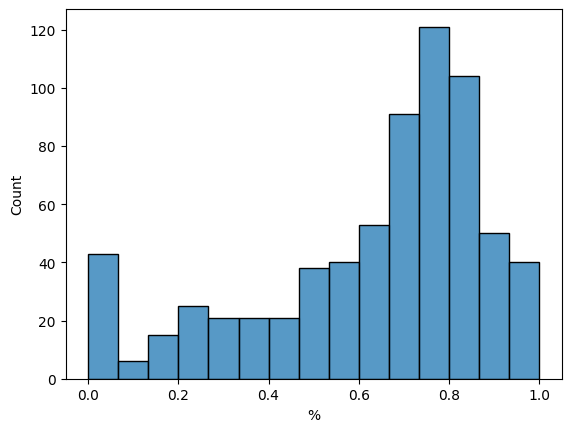

In [59]:
plot_ret(ret_fragments)

In [63]:
def plot_ret_pre(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['preimage_coverage'], 'all': r['ALL']['preimage_all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()

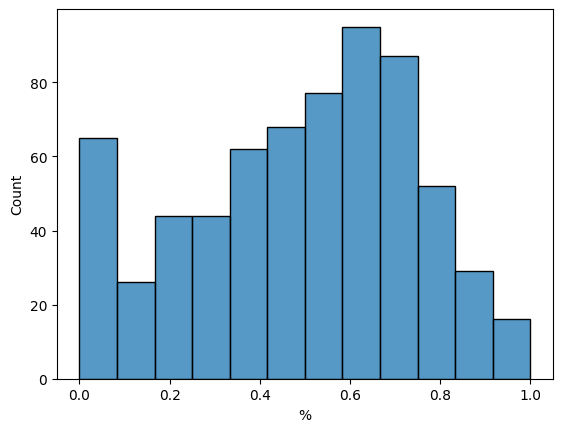

In [64]:
plot_ret_pre(ret_fragments)

In [65]:
with open("./matching_lines.json") as f:
    commits = json.load(f)
    
#commits

In [66]:
def ret_to_df(ret, name):
    df = []
    for rl in ret:
        if not (isinstance(rl, list) or isinstance(rl, tuple)):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({ 'id': rl[0],
                'PR' : r['ALL']['preimage_coverage'],
                       'PS' : r['ALL']['coverage'],
                       'all': r['ALL']['preimage_all'] + r['ALL']['all'],
                       'PR_all' : r['ALL']['preimage_all'],
                       'PS_all' : r['ALL']['all']
                      }
                     )
    df = pd.DataFrame(df)
    #display(df)
    
    df['postimage/all [%]'] = df['PS']/df['all']
    df['preimage /all [%]'] = df['PR']/df['all']
    df['name'] = name
    
    return df
    

def plot_ret_all(ret_dict, fname="distribution.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    
    df = pd.concat(dfs, keys=ret_dict.keys())
    
    # Show the joint distribution using kernel density estimation
    g = sns.jointplot(
        data=df,
        x="postimage/all [%]", y="preimage /all [%]", hue = 'name',
        kind="kde",
    )
    plt.savefig(fname)
    plt.show()

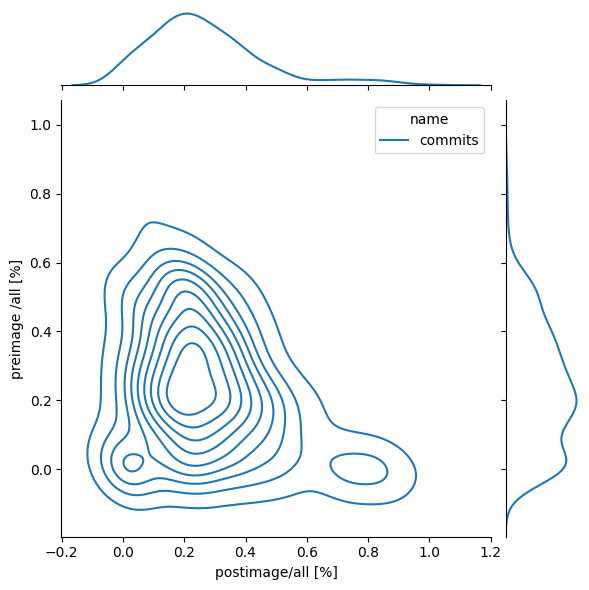

In [67]:
plot_ret_all({'commits':commits})

# PR sharings

In [79]:
pr_sharings_path = find_most_recent_pr_sharings(Path(dataset_dir), verbose=True)
print(f"Found '{pr_sharings_path}'")

with open(pr_sharings_path) as f:
    pr_data = json.load(f)

Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


Found '../data/external/DevGPT/snapshot_20231012/20231012_233628_pr_sharings.json'


In [68]:
#ret_fragments_pr = Parallel(n_jobs=1000)(delayed(run_joblib)(source, conv, compare=CompareFragments) for source in tqdm.tqdm(pr_data['Sources']) for conv in source['ChatgptSharing'])


## Read aggregated PR sharings CSV

In [20]:
df_pr = pd.read_csv("../data/interim/pr_sharings_df.csv")

In [21]:
df_pr.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title',
       'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State',
       'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount',
       'FirstCommitSha', 'LastCommitSha', 'Sha', 'StateOpen', 'StateClosed',
       'StateMerged', 'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'reviews.body_count'],
      dtype='object')

In [103]:
pr_sharings_path = find_most_recent_pr_sharings(Path(dataset_dir), verbose=True)
print(f"Found '{pr_sharings_path}'")

with open(pr_sharings_path) as f:
    pr_data_mergesha = json.load(f)

len(pr_data_mergesha['Sources'])

Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


Found '../data/external/DevGPT/snapshot_20231012/20231012_233628_pr_sharings.json'


267

In [104]:
sha_info = {
        'found': 0,
        'N/A': 0,
    }

for source in pr_data_mergesha['Sources']:
    try:
        source['Sha'] = df_pr[df_pr['URL'] == source['URL']]['Sha'].values[0]
        sha_info['found'] += 1
    except:
        source['Sha'] = np.nan
        sha_info['N/A'] += 1
        #print(df_pr[df_pr['URL'] == source['URL']]['Sha'])

print(f"found {sha_info['found']} merge 'Sha', {sha_info['N/A']} np.nan's")

found 267 merge 'Sha', 0 np.nan's


In [105]:
print(f"df_pr shape: {df_pr.shape}")
print(f"total number of 'ChatgptSharing's: {df_pr['NumberOfChatgptSharings'].sum()}")
print(f"total number of PR in latest sharing: {len(pr_data_mergesha['Sources'])}")

total_pr_sharings = df_pr['NumberOfChatgptSharings'].sum()

df_pr shape: (267, 37)
total number of 'ChatgptSharing's: 301
total number of PR in latest sharing: 267


In [107]:
# takes around 30 minutes to compute
with tqdm_joblib(tqdm.tqdm(desc="PR sharings data (merge)", total=total_pr_sharings)) as progress_bar:
    ret_fragments_pr = Parallel(n_jobs=1000)(
        delayed(run_joblib)(source, conv, compare=CompareFragments) 
        for source in pr_data_mergesha['Sources'] 
        for conv in source['ChatgptSharing']
    )

PR sharings data (merge): 100%|████████████████████████████████| 301/301 [27:06<00:00,  5.40s/it]


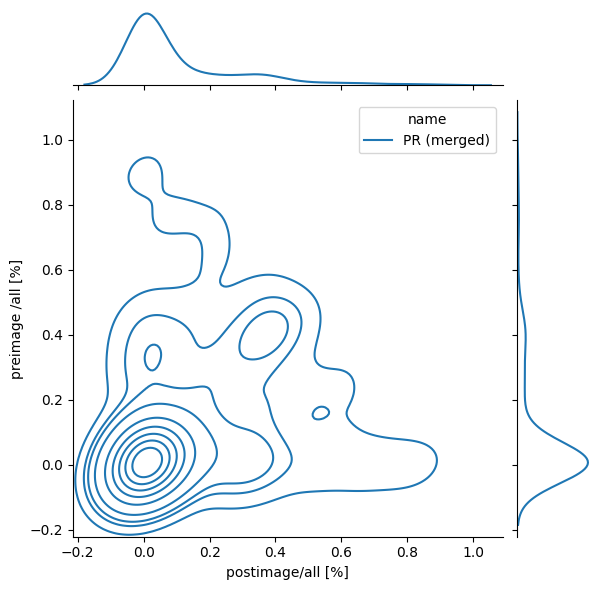

In [108]:
plot_ret_all({'PR (merged)': ret_fragments_pr})

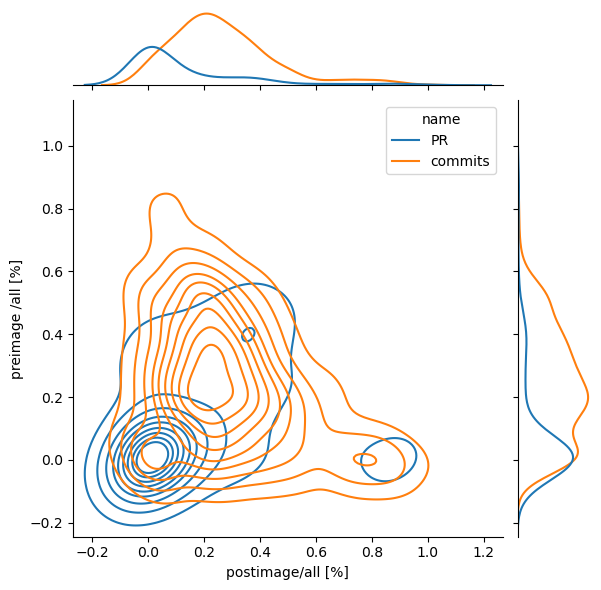

In [106]:
plot_ret_all({'PR (merged)': ret_fragments_pr, 'commits': commits})

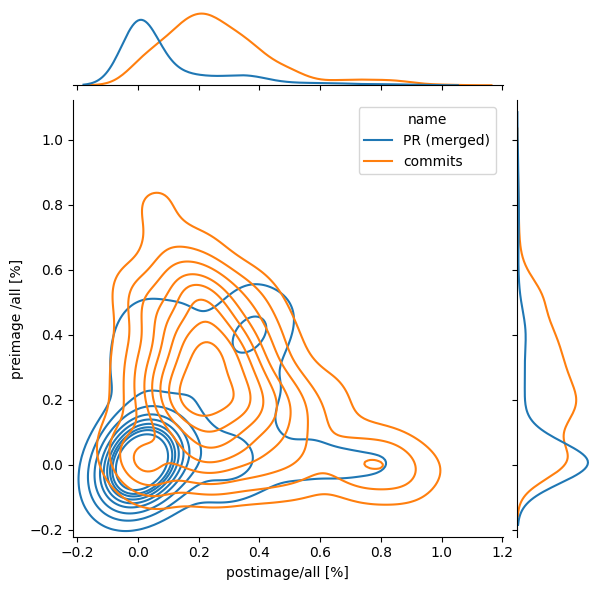

In [84]:
plot_ret_all({'PR (merged)': ret_fragments_pr, 'commits': commits})

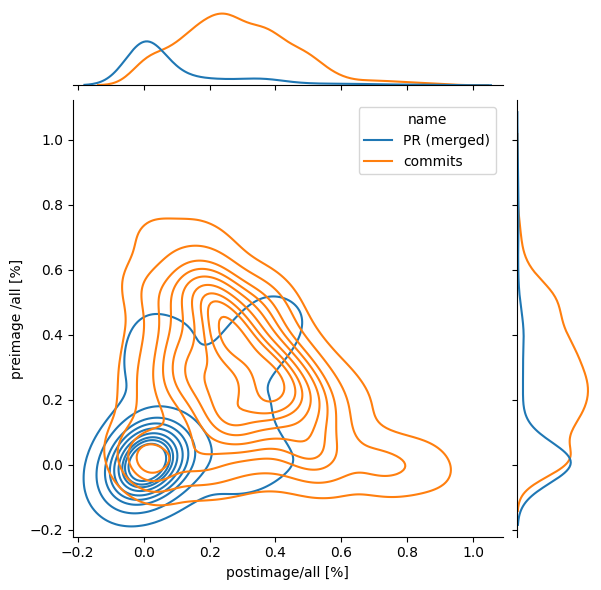

In [83]:
plot_ret_all({'PR (merged)': ret_fragments_pr, 'commits': ret_fragments})

## Read aggregated split PR sharings CSV (no plot_ret)

In [22]:
df_pr_split = pd.read_csv("../data/interim/pr_sharings_split_commit_df.csv")

In [23]:
df_pr_split.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number',
       'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions',
       'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'FirstCommitSha',
       'LastCommitSha', 'StateOpen', 'StateClosed', 'StateMerged',
       'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'reviews.body_count', 'CommitIdx', 'Sha'],
      dtype='object')

In [26]:
df_pr_split_group_by_url = df_pr_split.groupby(by='URL')

In [62]:
%time
df_pr_agg_sha = df_pr_split_group_by_url.agg(
    LastCommitIdx=pd.NamedAgg(column="CommitIdx", aggfunc="max"),
    # https://www.pythonforbeginners.com/basics/check-if-a-column-is-sorted-in-a-pandas-dataframe
    CommitIdxIsIncreasing=pd.NamedAgg(column="CommitIdx", aggfunc=lambda col: col.is_monotonic_increasing),
    FirstSha=pd.NamedAgg(column="Sha", aggfunc="first"),
    LastSha=pd.NamedAgg(column="Sha", aggfunc="last"),
)

display(df_pr_agg_sha)
display(df_pr_agg_sha['CommitIdxIsIncreasing'].value_counts())

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 30.3 µs


,LastCommitIdx,CommitIdxIsIncreasing,FirstSha,LastSha
URL,,,,
https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79,4,True,1c9e49a27057023ab5a1fd7e7f107d73938b34d9,f7f0ba5278ddf1d936fcd242165d97f4a295bb29
https://github.com/2Abendsegler/GClh/pull/2376,2,True,1585b67ab6a856c8d7b3f53c9b08617a2c662d0f,193c620d2e15f4e3cc59da22216a780b934b0242
https://github.com/4dn-dcic/foursight-core/pull/50,99,True,c4df9865ea585cffa8c57c401d10dadc6a7a1d44,fad3f4d4b2177c86f6d7e07b6f6cab9b3637cf74
https://github.com/AGnias47/AGnias47.github.io/pull/2,1,True,319ebd66922088c1240f694a98c4bb9aa860504f,9bba71d46c95d40a5ff7ef88b558fff0ce714e6a
https://github.com/ActivityWatch/aw-webui/pull/455,0,True,c93f546f2b9d2b97a6f340d4a1859f2aa80fd0a7,c93f546f2b9d2b97a6f340d4a1859f2aa80fd0a7
...,...,...,...,...
https://github.com/whatwg/whatwg.org/pull/427,1,True,26d19b578f9826122239a3dab041786720a31f9c,17fce19b86e696d7342d54ed13d576eca7770d77
https://github.com/xebia-functional/xef/pull/343,9,True,e0f2d1c2c4d66791fdfa1f1de3e5e5d486d4901e,4e1b5cfe8dcb8727c0c5b035d2d992e2803602bd
https://github.com/ykdojo/kaguya/pull/16,1,True,6663003bb5f85726225511986e2932b161c264c2,5d71d177ba8974a23738a7e3b191e0bdf663f042


CommitIdxIsIncreasing
True    267
Name: count, dtype: int64

In [48]:
example_url = 'https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79'
df_example_group = df_pr_split[df_pr_split['URL'] == example_url]
print(f"Examining group for URL = {example_url}")
print(f"'CommitIdx' column is monotonic increasing: {df_example_group['CommitIdx'].is_monotonic_increasing}")

df_example_group[['URL', 'CommitIdx', 'Sha']]

Examining group for URL = https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79
'CommitIdx' column is monotonic increasing: True


,URL,CommitIdx,Sha
714,https://github.com/23-OSSCA-python-mysql-repli...,0,1c9e49a27057023ab5a1fd7e7f107d73938b34d9
715,https://github.com/23-OSSCA-python-mysql-repli...,1,3b8255763edf2b4d4d410ae105b0b435c1710041
716,https://github.com/23-OSSCA-python-mysql-repli...,2,9bcf867dc9518ee5e048a6518f6ff33d02cc8aae
717,https://github.com/23-OSSCA-python-mysql-repli...,3,7cc0e713b05fd82def255cc1b0220228ee2f3d27
718,https://github.com/23-OSSCA-python-mysql-repli...,4,f7f0ba5278ddf1d936fcd242165d97f4a295bb29


## Re-run with improved "run_joblib"

The format of pr sharings file is described in<br>
https://github.com/NAIST-SE/DevGPT/blob/main/README.md#github-pull-request

In [86]:
pr_sharings_path

PosixPath('../data/external/DevGPT/snapshot_20231012/20231012_233628_pr_sharings.json')

In [95]:
def run_diff_to_conv(source, conv, compare):
    if 'Conversations' not in conv:
        tqdm.tqdm.write(f"no 'Conversations' for {source['URL']}")
        return None, {}, f"no 'Conversations' for {source['URL']}"
    
    all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'), verbose=False)

    R = source['RepoName']
    U = source['URL']
    if 'Sha' in source:
        S = source['Sha']
        P = None  # default to first parent of 'Sha'
    elif 'CommitSha' in source:
        if isinstance(source['CommitSha'], str):
            S = source['CommitSha']
            P = None  # default to first parent of 'Sha'
        else:  # assume it is a list, or equivalent
            S = source['CommitSha'][-1]  # latest
            P = source['CommitSha'][0] + '^'  # parent of earliest
    else:
        tqdm.tqdm.write(f"missing Sha or CommitSha for {U}")
        return U, {}, f"missing Sha or CommitSha for {U}"
    
    try:
        the_repo = all_repos.repo(R)
        curr_diff = the_repo.unidiff(commit=S, prev=P) 

        start = time.perf_counter()
        cmp_result = diff_to_conversation(curr_diff, conv, compare=compare)
        return U, cmp_result, time.perf_counter() - start
        
    except Exception as ex:
        #tqdm.tqdm.write(f"exception for {U}: {ex}")
        return U, {}, f"{type(ex)} exception for {U}: {ex}"

Re-read data files, to remove added 'Sha' _(which is merge commit, if PR was merged)_

In [90]:
pr_sharings_path = find_most_recent_pr_sharings(Path(dataset_dir), verbose=True)
print(f"Found '{pr_sharings_path}'")

with open(pr_sharings_path) as f:
    pr_data = json.load(f)

Found '../data/external/DevGPT/snapshot_20231012/20231012_233628_pr_sharings.json'


Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


In [91]:
df_pr = pd.read_csv("../data/interim/pr_sharings_df.csv")
df_pr.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title',
       'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State',
       'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount',
       'FirstCommitSha', 'LastCommitSha', 'Sha', 'StateOpen', 'StateClosed',
       'StateMerged', 'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'reviews.body_count'],
      dtype='object')

In [92]:
print(f"df_pr shape: {df_pr.shape}")
print(f"total number of 'ChatgptSharing's: {df_pr['NumberOfChatgptSharings'].sum()}")
print(f"total number of PR in latest sharing: {len(pr_data['Sources'])}")

total_pr_sharings = df_pr['NumberOfChatgptSharings'].sum()

df_pr shape: (267, 37)
total number of 'ChatgptSharing's: 301
total number of PR in latest sharing: 267


In [97]:
# this needs around 30 minutes to run
with tqdm_joblib(tqdm.tqdm(desc="PR sharings data (new)", total=total_pr_sharings)) as progress_bar:
    ret_fragments_pr_all = Parallel(n_jobs=-1)(
        delayed(run_diff_to_conv)(source, conv, compare=CompareFragments) 
        for source in pr_data['Sources'] 
        for conv in source['ChatgptSharing']
    )

PR sharings data (new): 100%|█████████████████████████████████▉| 300/301 [03:35<00:08,  8.49s/it]

no 'Conversations' for https://github.com/openai/evals/pull/771
no 'Conversations' for https://github.com/decred/dcrdex/pull/2333
no 'Conversations' for https://github.com/mindee/doctr/pull/1205
no 'Conversations' for https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tutor/pull/30
no 'Conversations' for https://github.com/gcarlos64/linux/pull/4
no 'Conversations' for https://github.com/WalletConnect/echo-server/pull/235
no 'Conversations' for https://github.com/aemartinez/gpt-latex-translator/pull/2
no 'Conversations' for https://github.com/daydule/frontend/pull/35
no 'Conversations' for https://github.com/rhysmorgan134/node-CarPlay/pull/70
no 'Conversations' for https://github.com/KomodoPlatform/komodo-wallet-mobile/pull/37
no 'Conversations' for https://github.com/JJConsulting/JJMasterData/pull/131
no 'Conversations' for https://github.com/SWM14-Architect/moview-core-service/pull/12
no 'Conversations' for https://github.com/aemartinez/gpt-latex-translator/pull/2
no 'Conversations' for https

PR sharings data (new): 100%|██████████████████████████████████| 301/301 [27:32<00:00,  5.49s/it]


My calculation:   0%|                                                  | 0/694 [4:49:21<?, ?it/s]


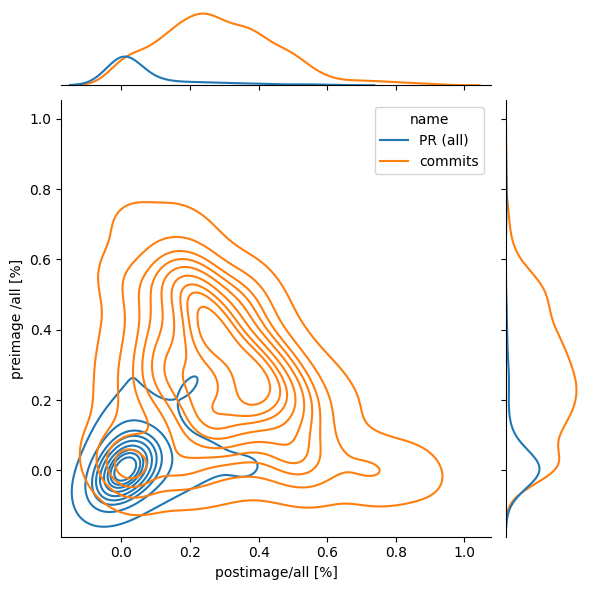

In [100]:
plot_ret_all({'PR (all)': ret_fragments_pr_all, 'commits': ret_fragments})

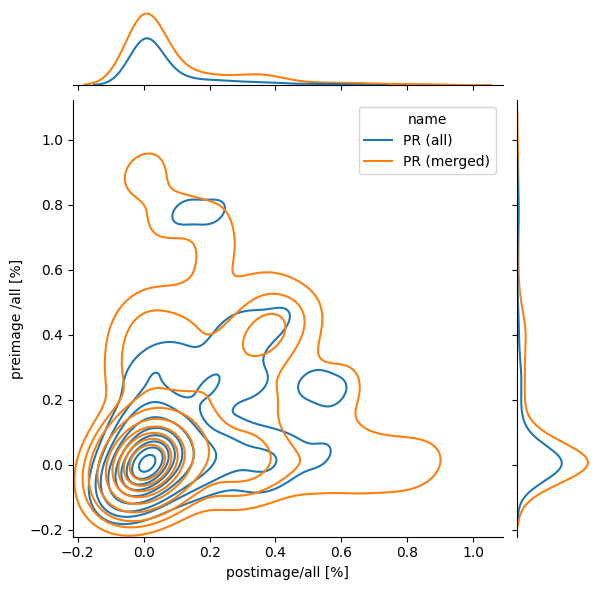

In [109]:
plot_ret_all({'PR (all)': ret_fragments_pr_all, 'PR (merged)': ret_fragments_pr})

# Issue sharings

In [122]:
print(f"dataset: '{dataset_dir}'")

issue_sharings_path = find_most_recent_issue_sharings(Path(dataset_dir), verbose=True)
print(f"Found '{issue_sharings_path}'")

with open(issue_sharings_path) as f:
    issue_data = json.load(f)

dataset: '../data/external/DevGPT'
Found '../data/external/DevGPT/snapshot_20231012/20231012_235128_issue_sharings.json'


Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


In [124]:
len(issue_data['Sources'])

507

The format of issue sharings file is described in<br>
https://github.com/NAIST-SE/DevGPT/blob/main/README.mdgithub-issue

**GitHub Issue**

| Attribute    | Description |
| -------- | ------- |
| Type  | Source type   |
| URL | URL to the mentioned source     |
| Author  | Author who introduced this mention   |
| RepoName    | Name of the repository that contains this issue     |
| RepoLanguage  | Primary programming language of the repository that contains thi  issue **_NOTE:_** it can be null when this repository does not contain any code |
| Number    | Issue number of this issue     |
| Title    | Title of this issue    |
| Body | Description of this issue     |
| AuthorAt  | When the author created this issue  |
| ClosedAt | When this issu *as closed  **_NOTE:_** it can be null when this issue is not closed |
| UpdatedAt | When the latest update of this issue occurred |
| State | The state of this issue (i.e., OPEN and CLOSED)  |
| ChatgptSharing    | List of ChatGPT link mentions. Refer to the `ChatgptSharing` structure for details  |t

**NOTE:** how there is no 'Sha' field there

## Read aggregated issue sharings CSV

That is why we need extra data extracted from GitHub, namely how issue was closed.

If it was closed with a PR (pull request), or via a commit, we have 'Sha'

In [126]:
df_issue = pd.read_csv("../data/interim/issue_sharings_df.csv")

In [127]:
df_issue.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title',
       'Body', 'CreatedAt', 'ClosedAt', 'UpdatedAt', 'State', 'StateOpen',
       'StateClosed', 'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'closer', 'url', 'Sha', 'closerMissing', 'closerCommit',
       'closerPullrequest'],
      dtype='object')

In [128]:
df_issue[['closerMissing', 'closerCommit', 'closerPullrequest']].value_counts()

closerMissing  closerCommit  closerPullrequest
False          False         True                 48
               True          False                21
Name: count, dtype: int64

In [129]:
df_issue[['closerMissing', 'closerCommit', 'closerPullrequest']].sum()

closerMissing         0
closerCommit         21
closerPullrequest    48
dtype: object

In [134]:
df_issue_shas_count = df_issue[['closerMissing', 'closerCommit', 'closerPullrequest']].sum().sum()
df_issue_shas_count

69

In [135]:
df_issue['Sha'].count()

69

In [137]:
print(f"{df_issue.shape=}")
print(f"issue_data len: {len(issue_data['Sources'])}")
print(f"{df_issue_shas_count}")

df_issue.shape=(510, 33)
issue_data len: 507
69


In [139]:
s_url = df_issue['URL'].value_counts()
s_url

URL
https://github.com/openactive/dataset-utils/issues/2                   2
https://github.com/42Seoul-IRC/ft_irc/issues/72                        2
https://github.com/pionxzh/chatgpt-exporter/issues/168                 2
https://github.com/mgroves/realworld-aspnet-couchbase/issues/11        1
https://github.com/D3Zyre/Copy-All-Files-From-Folder/issues/17         1
                                                                      ..
https://github.com/soulhighwing/LocalGPT/issues/2                      1
https://github.com/ubiquity/ubiquibot/issues/746                       1
https://github.com/zsviczian/obsidian-excalidraw-plugin/issues/1319    1
https://github.com/clojure-emacs/orchard/issues/186                    1
https://github.com/MatrixAI/js-quic/issues/24                          1
Name: count, Length: 507, dtype: int64

In [145]:
dup_urls_list = s_url[s_url > 1].index.values
dup_urls_list

array(['https://github.com/openactive/dataset-utils/issues/2',
       'https://github.com/42Seoul-IRC/ft_irc/issues/72',
       'https://github.com/pionxzh/chatgpt-exporter/issues/168'],
      dtype=object)

In [146]:
df_issue[df_issue['URL'].isin(dup_urls_list)]

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,...,Status404,title_count,body_count,comments.body_count,closer,url,Sha,closerMissing,closerCommit,closerPullrequest
140,issue,https://github.com/openactive/dataset-utils/is...,civsiv,openactive/dataset-utils,HTML,2,Add tests to https://github.com/openactive/dat...,See example tests here: https://chat.openai.co...,2023-09-07T09:41:23Z,2023-10-05T16:47:20Z,...,0,0,1,0,PullRequest,https://github.com/openactive/dataset-utils/pu...,46454ce013867533c61254b905b8b7157a83e79f,False,False,True
141,issue,https://github.com/openactive/dataset-utils/is...,civsiv,openactive/dataset-utils,HTML,2,Add tests to https://github.com/openactive/dat...,See example tests here: https://chat.openai.co...,2023-09-07T09:41:23Z,2023-10-05T16:47:20Z,...,0,0,1,0,PullRequest,https://github.com/openactive/dataset-utils/pu...,e5ab7ec72a159e236259cc8446b69fd41c2657f2,False,False,True
151,issue,https://github.com/pionxzh/chatgpt-exporter/is...,kyoyacchi,pionxzh/chatgpt-exporter,TypeScript,168,Broken view on share links (mobile),![Screenshot_20230919-183743](https://github.c...,2023-09-19T15:38:46Z,2023-09-25T16:59:23Z,...,1,0,1,0,PullRequest,https://github.com/pionxzh/chatgpt-exporter/pu...,2b6b12e71d0af1cc32aa764c2c4286c62964c5e2,False,False,True
152,issue,https://github.com/pionxzh/chatgpt-exporter/is...,kyoyacchi,pionxzh/chatgpt-exporter,TypeScript,168,Broken view on share links (mobile),![Screenshot_20230919-183743](https://github.c...,2023-09-19T15:38:46Z,2023-09-25T16:59:23Z,...,1,0,1,0,PullRequest,https://github.com/pionxzh/chatgpt-exporter/pu...,484ea8c3e2970806154bde8cee098faa158f2f06,False,False,True
315,issue,https://github.com/42Seoul-IRC/ft_irc/issues/72,Tolerblanc,42Seoul-IRC/ft_irc,C++,72,보너?스,- [x] File Transfer with Reference Client\r\n-...,2023-07-24T11:25:06Z,2023-07-27T02:44:07Z,...,0,0,0,1,PullRequest,https://github.com/42Seoul-IRC/ft_irc/pull/75,c13694d18f9b0b49db457c4934562bde1f8b29ca,False,False,True
316,issue,https://github.com/42Seoul-IRC/ft_irc/issues/72,Tolerblanc,42Seoul-IRC/ft_irc,C++,72,보너?스,- [x] File Transfer with Reference Client\r\n-...,2023-07-24T11:25:06Z,2023-07-27T02:44:07Z,...,0,0,0,1,PullRequest,https://github.com/42Seoul-IRC/ft_irc/pull/76,c4920744ab9af63c659198bf08ad033b902ee83f,False,False,True


In [151]:
df_issue_by_url = df_issue.groupby('URL').agg('first')
df_issue_by_url.head()

,Type,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,UpdatedAt,...,Status404,title_count,body_count,comments.body_count,closer,url,Sha,closerMissing,closerCommit,closerPullrequest
URL,,,,,,,,,,,,,,,,,,,,,
https://github.com/2Abendsegler/GClh/issues/2416,issue,capoaira,2Abendsegler/GClh,JavaScript,2416,[Global] Problems with header on Safari,### Describe the bug\n\nhttps://www.geoclub.de...,2023-08-01T14:31:40Z,None,2023-08-02T06:25:31Z,...,0,0,1,0,None,None,None,None,None,None
https://github.com/42Seoul-IRC/ft_irc/issues/72,issue,Tolerblanc,42Seoul-IRC/ft_irc,C++,72,보너?스,- [x] File Transfer with Reference Client\r\n-...,2023-07-24T11:25:06Z,2023-07-27T02:44:07Z,2023-07-27T02:44:07Z,...,0,0,0,1,PullRequest,https://github.com/42Seoul-IRC/ft_irc/pull/75,c13694d18f9b0b49db457c4934562bde1f8b29ca,False,False,True
https://github.com/AIToolsLab/questions/issues/5,issue,kcarnold,AIToolsLab/questions,Jupyter Notebook,5,Design a way to evaluate question generation a...,- Can we generate questions of various types?\...,2023-06-06T17:07:57Z,None,2023-06-20T14:38:03Z,...,0,0,0,1,None,None,None,None,None,None
https://github.com/AVI-SHUKLA1110/websec-/issues/1,issue,csrsaviar,AVI-SHUKLA1110/websec-,None,1,hi!,https://chat.openai.com/share/131a7d4c-ef80-46...,2023-06-30T11:36:31Z,None,2023-06-30T11:36:31Z,...,0,0,1,0,None,None,None,None,None,None
https://github.com/AceCentre/RelayKeys/issues/149,issue,quaxalber,AceCentre/RelayKeys,Python,149,Expand language support,**Is your feature request related to a problem...,2023-08-20T08:29:07Z,None,2023-10-05T12:16:36Z,...,0,0,1,0,None,None,None,None,None,None


In [153]:
df_issue_by_url.loc['https://github.com/openactive/dataset-utils/issues/2', 'Sha']

'46454ce013867533c61254b905b8b7157a83e79f'

In [156]:
df_issue_by_url.loc['https://github.com/AIToolsLab/questions/issues/5', 'Sha'] is None

True

In [157]:
df_issue['closer'].value_counts()

closer
PullRequest    48
Commit         21
Name: count, dtype: int64

In [159]:
sha_info = {
    'found': 0,
    'N/A': 0,
}

issue_data_by_pr = []
issue_data_by_commit = []

for source in issue_data['Sources']:
    url = source['URL']
    sha = df_issue_by_url.loc[url, 'Sha']
    if sha is not None:
        source['Sha'] = sha
        sha_info['found'] += 1
    else:
        source['Sha'] = np.nan
        sha_info['N/A'] += 1
        #print(df_pr[df_pr['URL'] == source['URL']]['Sha'])

    closer = sha = df_issue_by_url.loc[url, 'closer']
    if closer == 'Commit':
        issue_data_by_commit.append(source)
    elif closer == 'PullRequest':
        issue_data_by_pr.append(source)


print(f"found {sha_info['found']} issue 'Sha', {sha_info['N/A']} are now np.nan's")
print(f"for total {len(issue_data['Sources'])}")
print(f"{len(issue_data_by_commit)} closer 'Commit'")
print(f"{len(issue_data_by_pr)} closer 'PullRequest'")

found 66 issue 'Sha', 441 are now np.nan's
for total 507
21 closer 'Commit'
45 closer 'PullRequest'


In [160]:
print(f"df_issue shape: {df_issue.shape}")
print(f"total number of 'ChatgptSharing's: {df_issue['NumberOfChatgptSharings'].sum()}")
print(f"total number of PR in latest sharing: {len(issue_data['Sources'])}")

total_issue_sharings = df_issue['NumberOfChatgptSharings'].sum()
total_issue_sha = df_issue['Sha'].count()

df_issue shape: (510, 33)
total number of 'ChatgptSharing's: 639
total number of PR in latest sharing: 507


## Perform computations and plots

In [161]:
with tqdm_joblib(tqdm.tqdm(desc="issue sharings data", total=total_issue_sharings)) as progress_bar:
    ret_fragments_issue = Parallel(n_jobs=-1)(
        delayed(run_diff_to_conv)(source, conv, compare=CompareFragments) 
        for source in issue_data['Sources'] 
        for conv in source['ChatgptSharing']
    )

issue sharings data: 100%|████████████████████████████████████▊| 636/639 [01:35<00:00,  6.63it/s]


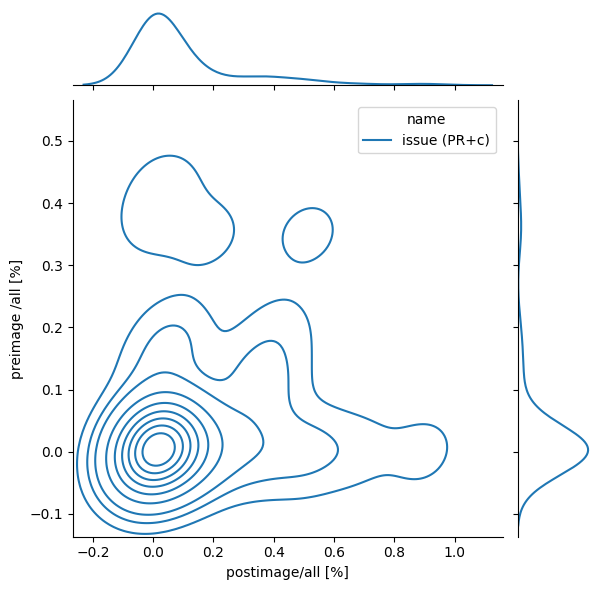

In [162]:
plot_ret_all({'issue (PR+c)': ret_fragments_issue})

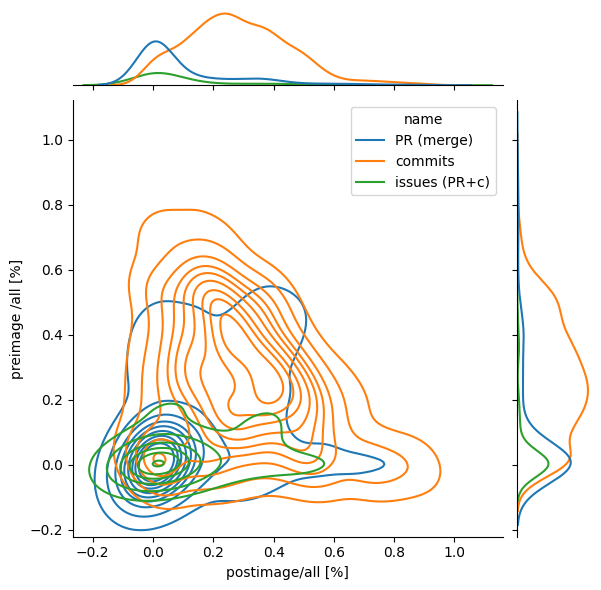

no 'Conversations' for https://github.com/SKKUFastech/week1/issues/3
no 'Conversations' for https://github.com/prosyslab-classroom/cs348-information-security/issues/365
no 'Conversations' for https://github.com/SKKUFastech/week1/issues/3
no 'Conversations' for https://github.com/albertobsd/keyhunt/issues/115
no 'Conversations' for https://github.com/SKKUFastech/week1/issues/3
no 'Conversations' for https://github.com/SKKUFastech/week1/issues/3
no 'Conversations' for https://github.com/kaist-cp/cs220/issues/276
no 'Conversations' for https://github.com/SKKUFastech/week1/issues/3
no 'Conversations' for https://github.com/dsnobes/MSPM/issues/14
no 'Conversations' for https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tutor/issues/56
no 'Conversations' for https://github.com/simonw/sqlite-chronicle/issues/4
no 'Conversations' for https://github.com/kreait/firebase-php/issues/802
no 'Conversations' for https://github.com/mgroves/realworld-aspnet-couchbase/issues/11
no 'Conversations' for https://gi

In [163]:
plot_ret_all({'PR (merge)': ret_fragments_pr, 'commits': ret_fragments, 'issues (PR+c)': ret_fragments_issue})

# `plot_ret_diff`

In [100]:
def plot_ret_diff(ret_dict, fname="histograms.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    df = pd.concat(dfs, keys=ret_dict.keys())

    df['diff'] = (df['PS'] - df['PR'])/df['all']
    #sns.histplot(df, x='diff', hue='name', multiple='dodge')
    sns.displot(df, x="diff", col="name",)
    plt.show()
    plt.savefig(fname)
    display(df)

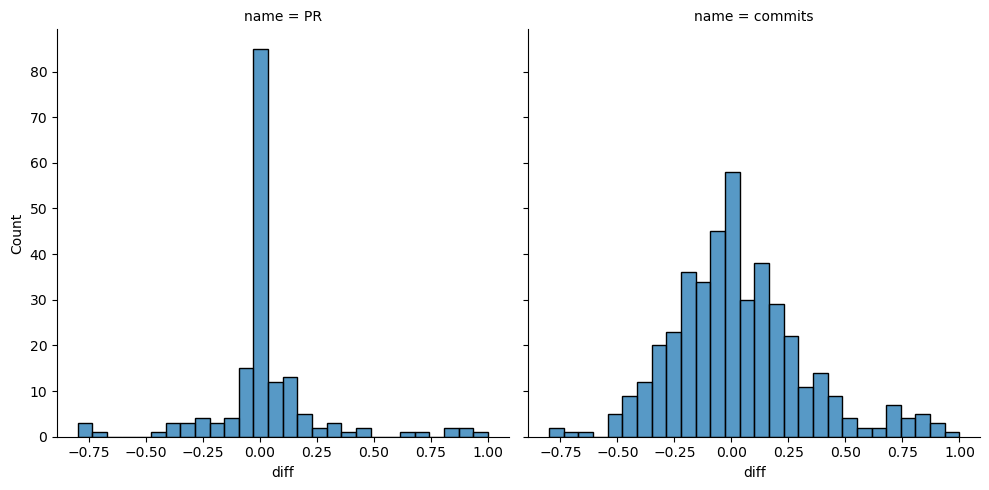

PR   PS   all  postimage/all [%]  preimage /all [%]     name  \
PR      0    710  274  1714           0.159860           0.414236       PR   
        1    823  632  1714           0.368728           0.480163       PR   
        2    696  349  1714           0.203617           0.406068       PR   
        3    615  636  1714           0.371062           0.358810       PR   
        4      0   20    58           0.344828           0.000000       PR   
...          ...  ...   ...                ...                ...      ...   
commits 424   13   26    76           0.342105           0.171053  commits   
        425   79   27   135           0.200000           0.585185  commits   
        426   20   88   141           0.624113           0.141844  commits   
        427    0    0    12           0.000000           0.000000  commits   
        428   84   86   207           0.415459           0.405797  commits   

                 diff  
PR      0   -0.254376  
        1   -0.111435  
        2   -0.202450  
        3    0.012252  
        4    0.344828  
...               ...  
commits 424  0.171053  
        425 -0.385185  
        426  0.482270  
        427  0.000000  
        428  0.009662  

[596 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

In [101]:
plot_ret_diff({'PR': ret_fragments_pr, 'commits': commits})

In [1]:
#pr_data

# Generating flow diagram

In [110]:
ret = []

for source in pr_data_mergesha['Sources']:
    ret.append({'ds':'PR', 'state':source['State'], 'URL':source['URL'], 'count':1})

    

In [111]:
df_pr_state = pd.DataFrame(ret)#.groupby(['ds', 'state']).count().reset_index().to_csv(index=False))
display(df_pr_state['state'].unique())

display(df_pr_state)

array(['OPEN', 'MERGED', 'CLOSED'], dtype=object)

,ds,state,URL,count
0,PR,OPEN,https://github.com/validatorjs/validator.js/pu...,1
1,PR,OPEN,https://github.com/magnifiq/js-practice-ventio...,1
2,PR,OPEN,https://github.com/FlorianWoelki/obsidian-symb...,1
3,PR,OPEN,https://github.com/asaskevich/govalidator/pull...,1
4,PR,OPEN,https://github.com/rom-py/rompy/pull/40,1
...,...,...,...,...
262,PR,MERGED,https://github.com/VOICEVOX/voicevox_core/pull...,1
263,PR,MERGED,https://github.com/MatrixAI/Polykey/pull/552,1
264,PR,MERGED,https://github.com/VOICEVOX/voicevox_core/pull...,1
265,PR,MERGED,https://github.com/VOICEVOX/voicevox/pull/1374,1


In [112]:
def merge_data(ret_dict, fname="histograms.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    df = pd.concat(dfs, keys=ret_dict.keys())
    df['match / postimage [%]'] = df['PS'] / df['PS_all']

    return df

In [113]:
combined = merge_data({'PR': ret_fragments_pr, 'commits': commits})
combined = combined.reset_index()

In [114]:
combined

,level_0,level_1,id,PR,PS,all,PR_all,PS_all,postimage/all [%],preimage /all [%],name,match / postimage [%]
0,PR,0,https://github.com/whatwg/whatwg.org/pull/427,0,0,5,4,1,0.000000,0.000000,PR,0.000000
1,PR,1,https://github.com/lightward/mechanic-tasks/pu...,0,73,147,24,123,0.496599,0.000000,PR,0.593496
2,PR,2,https://github.com/polywrap/evo.ninja/pull/206,7,2,9,7,2,0.222222,0.777778,PR,1.000000
3,PR,3,https://github.com/polywrap/evo.ninja/pull/206,7,1,9,7,2,0.111111,0.777778,PR,0.500000
4,PR,4,https://github.com/polywrap/evo.ninja/pull/206,0,0,9,7,2,0.000000,0.000000,PR,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
643,commits,424,https://github.com/hoshotakamoto/banzukesurfin...,13,26,76,34,42,0.342105,0.171053,commits,0.619048
644,commits,425,https://github.com/hoshotakamoto/banzukesurfin...,79,27,135,102,33,0.200000,0.585185,commits,0.818182
645,commits,426,https://github.com/hoshotakamoto/banzukesurfin...,20,88,141,35,106,0.624113,0.141844,commits,0.830189
646,commits,427,https://github.com/openai/evals/commit/771dce8...,0,0,12,0,12,0.000000,0.000000,commits,0.000000


In [115]:
combined['cat'] = pd.cut(combined['match / postimage [%]'], [-0.01,0.25,0.5, 0.75, 1.1])

In [116]:
print(combined.groupby(['name','cat']).count().reset_index()[['name', 'cat', 'PS']].to_csv(index=False))

name,cat,PS
PR,"(-0.01, 0.25]",155
PR,"(0.25, 0.5]",23
PR,"(0.5, 0.75]",15
PR,"(0.75, 1.1]",24
commits,"(-0.01, 0.25]",53
commits,"(0.25, 0.5]",52
commits,"(0.5, 0.75]",129
commits,"(0.75, 1.1]",193



/tmp/ipykernel_1460398/3081345061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(combined.groupby(['name','cat']).count().reset_index()[['name', 'cat', 'PS']].to_csv(index=False))


In [117]:
df_all = combined.merge(df_pr_state, how='outer', left_on='id', right_on='URL')
df_all['state'].fillna("MERGED", inplace=True)
df_all['name'].fillna('PR', inplace=True)

df_all['lstate'] = df_all['state'].map(lambda x: 'NOT MERGED' if x != 'MERGED' else x)
df_all['lcat'] = df_all['cat'].astype(str)
df_all['lcat'] = df_all['lcat'].map(lambda x: "(-0.01, 0.25]" if x =="nan" else x)
df_all['lcat'] = df_all['name'].str[0] + " " + df_all['lcat']

df_all.groupby(['state']).count()

,level_0,level_1,id,PR,PS,all,PR_all,PS_all,postimage/all [%],preimage /all [%],name,match / postimage [%],cat,ds,URL,count,lstate,lcat
state,,,,,,,,,,,,,,,,,,
CLOSED,0,0,0,0,0,0,0,0,0,0,38,0,0,38,38,38,38,38
MERGED,645,645,645,645,645,645,645,645,643,643,658,641,641,229,229,229,658,658
OPEN,3,3,3,3,3,3,3,3,3,3,28,3,3,28,28,28,28,28


In [118]:

flow = df_all.groupby(['name','lcat', 'lstate']).count().reset_index()

In [119]:
#flow['lcat'] = flow['name'].str[0] + " " +flow['cat'].astype(str)

flow['C'] = flow[['id','count']].values.max(1)

In [120]:
print(flow[flow['C']>0][['name', 'lcat', 'C']].to_csv(index=False))

name,lcat,C
PR,"P (-0.01, 0.25]",168
PR,"P (-0.01, 0.25]",65
PR,"P (0.25, 0.5]",22
PR,"P (0.25, 0.5]",1
PR,"P (0.5, 0.75]",15
PR,"P (0.75, 1.1]",24
commits,"c (-0.01, 0.25]",55
commits,"c (0.25, 0.5]",52
commits,"c (0.5, 0.75]",129
commits,"c (0.75, 1.1]",193



In [121]:
print(flow[flow['C']>0][['lcat', 'lstate', 'C']].to_csv(index=False))

lcat,lstate,C
"P (-0.01, 0.25]",MERGED,168
"P (-0.01, 0.25]",NOT MERGED,65
"P (0.25, 0.5]",MERGED,22
"P (0.25, 0.5]",NOT MERGED,1
"P (0.5, 0.75]",MERGED,15
"P (0.75, 1.1]",MERGED,24
"c (-0.01, 0.25]",MERGED,55
"c (0.25, 0.5]",MERGED,52
"c (0.5, 0.75]",MERGED,129
"c (0.75, 1.1]",MERGED,193

